<a href="https://colab.research.google.com/github/aiooq/Files/blob/master/NLP_telegram_bot_multiclass.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Загружаем необходимые инструменты

In [26]:
!pip install deep_translator
!pip install langdetect
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')
nltk.download('punkt')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### Подключаем библиотеки

In [27]:
from collections import OrderedDict
from nltk.corpus import wordnet, stopwords
from nltk.tokenize import word_tokenize
from deep_translator import GoogleTranslator
from langdetect import detect
import re

### Функции

In [28]:
def get_synonyms_en(word):
  synonyms = [lm.name().replace('_','') 
              for syn in wordnet.synsets(word) 
                for lm in syn.lemmas()]
  return list(OrderedDict.fromkeys(synonyms))

In [29]:
def get_translate(item, target = 'en', source = "auto"):
  if target in ['mk','bg','uk']:
      target = 'ru'
  if type(item)==list:
    result = list(OrderedDict.fromkeys(
                    [GoogleTranslator(source, target).translate(word) 
                        for word in item]))
  else:
    result = GoogleTranslator(source, target).translate(item)
  return result

In [30]:
def get_words_en(sentence):
  lang = detect(sentence)
  if lang in ['mk','bg','uk']:
      lang = 'ru'
  translated = get_translate(sentence)
  translated = re.sub(r'[!@"“’«»#$%&\'()*+,.—/:;<=>?^_`{|}~\[\]]','', translated)
  words = [word.lower() for word in word_tokenize(translated) 
                              if not word.lower() in stopwords.words('english')]
  print(f"[{lang}]:{sentence} -> {words}")
  return words, lang

In [31]:
def get_sentences(text):
  return re.split(r'\.',text)

# DS

### Данные

In [32]:
answers = ('Sending chart',
           'Sent a support request',
           'Thank you!',
           'Sending a report',
           'Could not find an answer, sent a support request',
           'Hello!')

examples = (('Отправь график свечей D1.',0),
            ('отправь график',0),
            ('график',0),
            ('граф',0),
            ('Очень критическая ошибка или бага на графике D1.',1),
            ('ошибкка где-то.',1),
            ('нужна помощь',1),
            ('Огромное вам спасибо за продукт, проект, программу и большая благодарность.',2),
            ('Спасибо',2),
            ('Спасибо за помощь',2),
            ('отправь отчет за эту неделю',3),
            ('сформируй отчет по чему-нибудь',3),
            ('Какая сегодня погода?',4),
            ('Включи чайник',4),
            ('Расскажи сказку',4),
            ('Хочется пообщаться, давай поговорим',4),
            ('Привет',5),
            ('Приветствую',5),
            ('Здравствуйте',5))

In [33]:
patterns = []
for i in examples:
  patterns.append([get_words_en(i[0]),i[1]])
patterns

[ru]:Отправь график свечей D1. -> ['submit', 'd1', 'candlestick', 'chart']
[ru]:отправь график -> ['send', 'schedule']
[ru]:график -> ['graphic']
[ru]:граф -> ['graph']
[ru]:Очень критическая ошибка или бага на графике D1. -> ['critical', 'error', 'bug', 'd1', 'chart']
[ru]:ошибкка где-то. -> ['error', 'somewhere']
[ru]:нужна помощь -> ['need', 'help']
[ru]:Огромное вам спасибо за продукт, проект, программу и большая благодарность. -> ['thank', 'much', 'product', 'project', 'program', 'big', 'thank']
[ru]:Спасибо -> ['thanks']
[ru]:Спасибо за помощь -> ['thanks', 'help']
[ru]:отправь отчет за эту неделю -> ['send', 'report', 'week']
[ru]:сформируй отчет по чему-нибудь -> ['write', 'report', 'something']
[ru]:Какая сегодня погода? -> ['weather', 'today']
[ru]:Включи чайник -> ['turn', 'kettle']
[ru]:Расскажи сказку -> ['tell', 'story']
[ru]:Хочется пообщаться, давай поговорим -> ['want', 'talk', 'lets', 'talk']
[ru]:Привет -> ['hi']
[ru]:Приветствую -> ['greetings']
[ru]:Здравствуйте ->

[[(['submit', 'd1', 'candlestick', 'chart'], 'ru'), 0],
 [(['send', 'schedule'], 'ru'), 0],
 [(['graphic'], 'ru'), 0],
 [(['graph'], 'ru'), 0],
 [(['critical', 'error', 'bug', 'd1', 'chart'], 'ru'), 1],
 [(['error', 'somewhere'], 'ru'), 1],
 [(['need', 'help'], 'ru'), 1],
 [(['thank', 'much', 'product', 'project', 'program', 'big', 'thank'], 'ru'),
  2],
 [(['thanks'], 'ru'), 2],
 [(['thanks', 'help'], 'ru'), 2],
 [(['send', 'report', 'week'], 'ru'), 3],
 [(['write', 'report', 'something'], 'ru'), 3],
 [(['weather', 'today'], 'ru'), 4],
 [(['turn', 'kettle'], 'ru'), 4],
 [(['tell', 'story'], 'ru'), 4],
 [(['want', 'talk', 'lets', 'talk'], 'ru'), 4],
 [(['hi'], 'ru'), 5],
 [(['greetings'], 'ru'), 5],
 [(['hello'], 'ru'), 5]]

### Формируем Bag words

In [34]:
bag_words = []
word_added = []

for pattern in patterns:
  words = list(OrderedDict.fromkeys(pattern[0][0]))

  for word in words:

    if word in word_added: 
      continue
    else:
      word_added.append(word)

    pouch = get_translate(get_synonyms_en(get_translate(word)))

    if len(pouch) == 0:
      pouch = [word]
    
    bag_words.append(pouch)

bag_words

[['submit',
  'subject',
  'state',
  'putforward',
  'posit',
  'present',
  'relegate',
  'pass on',
  'bow',
  'defer',
  'accede',
  'givein',
  'take',
  'putin',
  'render',
  'resign',
  'reconcile'],
 ['d1'],
 ['candlestick', 'candleholder'],
 ['chart', 'graph'],
 ['send',
  'direct',
  'sendout',
  'mail',
  'post',
  'transport',
  'ship',
  'station',
  'place',
  'getoff',
  'sendoff',
  'commit',
  'institutionalize',
  'institutionalise',
  'charge',
  'air',
  'broadcast',
  'beam',
  'transmit'],
 ['agenda', 'docket', 'schedule'],
 ['graphic',
  'computergraphic',
  'graphical',
  'inwriting',
  'lifelike',
  'pictorial',
  'vivid'],
 ['graph', 'graphicalrecord', 'chart'],
 ['critical', 'vital', 'decisive'],
 ['mistake',
  'error',
  'fault',
  'erroneousness',
  'erroneousbelief',
  'misplay',
  'wrongdoing',
  'computererror'],
 ['bug',
  'glitch',
  'hemipterousinsect',
  'hemipteran',
  'hemipteron',
  'microbe',
  'germ',
  'tease',
  'badger',
  'pester',
  'belea

### Формирует dataset на основе Bag words и patterns

In [35]:
def get_x(pattern):
  x = []
  for pouch in bag_words:
    value = 0
    for word in pouch:
      if word in pattern[0][0]:
        value = 1
        break
    x.append(value)
  return x

In [36]:
X = [get_x(pattern) for pattern in patterns]
y = [pattern[1] for pattern in patterns]

print(X)
print(y)

[[1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

### Подключаем библиотеки

In [37]:
from sklearn import datasets
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC

Обучаем модель

In [38]:
model = OneVsRestClassifier(LinearSVC(random_state=42)).fit(X, y)
print(y)

[0, 0, 0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 4, 4, 4, 4, 5, 5, 5]


In [39]:
model.predict(X)

array([0, 0, 0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 4, 4, 4, 4, 5, 5, 5])

### Тестирование

In [40]:
def answer(doc):
  patterns = [[get_words_en(sentence.strip())] 
              for sentence in get_sentences(doc)]
  X = [get_x(pattern) for pattern in patterns]
  Y = model.predict(X)
  result = [get_translate(answers[value],patterns[i][0][1]) 
            for i,value in enumerate(Y)]
  print(result)
  return Y,result

In [41]:
doc = 'Большая баг. отправь мне отчет за эту неделю. и ещё мне нужен график по символу USD'
#doc = 'un error en el programa. envíame un informe para esta semana'

In [42]:
patterns = [[get_words_en(sentence.strip())] for sentence in get_sentences(doc)]
patterns

[ru]:Большая баг -> ['big', 'bug']
[ru]:отправь мне отчет за эту неделю -> ['send', 'report', 'week']
[ru]:и ещё мне нужен график по символу USD -> ['also', 'need', 'chart', 'usd', 'symbol']


[[(['big', 'bug'], 'ru')],
 [(['send', 'report', 'week'], 'ru')],
 [(['also', 'need', 'chart', 'usd', 'symbol'], 'ru')]]

In [43]:
X = [get_x(pattern) for pattern in patterns]
Y = model.predict(X)
result = [get_translate(answers[value],patterns[i][0][1]) for i,value in enumerate(Y)]
result

['Привет!', 'Отправка отчета', 'Отправка диаграммы']

### Встраиваем NLP в телеграм бота

In [44]:
!pip install PyTelegramBotAPI

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


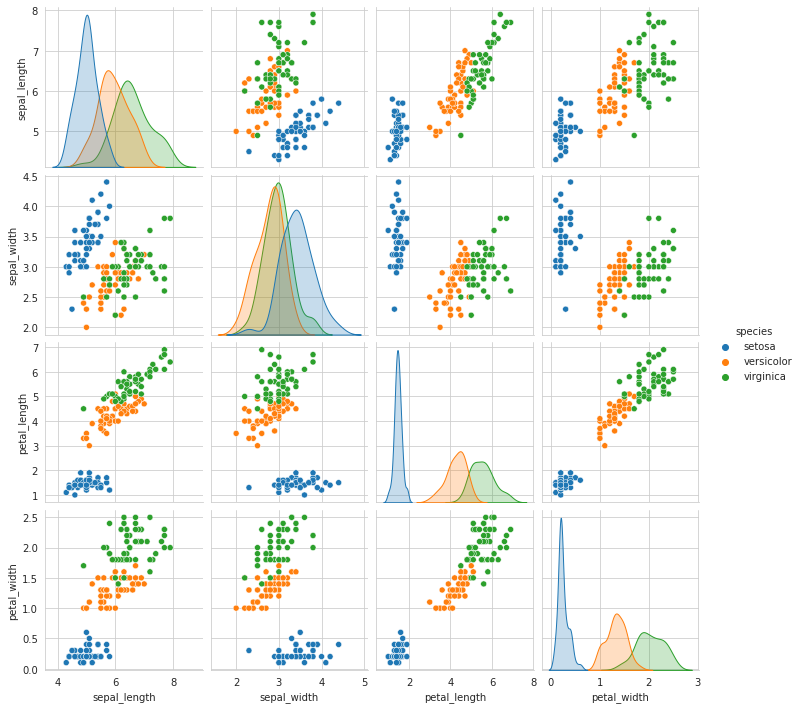

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt

df = sns.load_dataset("iris")
df['species'].unique()
sns.pairplot(df, hue="species")
plt.savefig('report.png')

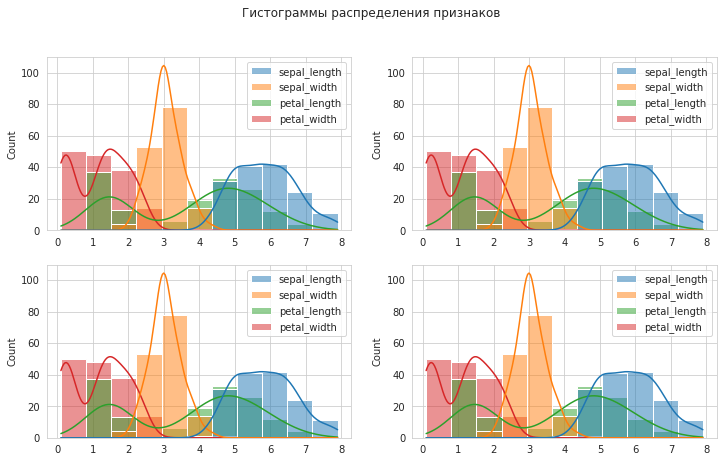

In [46]:
sns.set_style('whitegrid')
fig, ax = plt.subplots(2, 2, figsize=(12, 7))
plt.suptitle('Гистограммы распределения признаков')

sns.histplot(ax=ax[0, 0], data=df, kde=True)
sns.histplot(ax=ax[0, 1], data=df, kde=True)
sns.histplot(ax=ax[1, 0], data=df, kde=True)
sns.histplot(ax=ax[1, 1], data=df, kde=True)
plt.savefig('chart.png')
plt.show()

In [47]:
import telebot

In [48]:
#name = NLP_aiooq_bot, чтобы найти в телеграме
bot = telebot.TeleBot('5790070237:AAHe0Skg9k1TDVjILeoLVBCXWoX0hcXmFSE');

@bot.message_handler(commands=["start"])
def start(m, res=False):
    bot.send_message(m.chat.id, 'Hi 👋')

@bot.message_handler(content_types=["text"])
def handle_text(message):
    print(message)
    list_id, list_text = answer(message.text)
    bot.send_message(message.chat.id, ', '.join(list_text))
    if 3 in list_id:
      bot.send_photo(message.chat.id, open('report.png', 'rb'))
    if 0 in list_id:
      bot.send_photo(message.chat.id, open('chart.png', 'rb'))      

In [49]:
bot.polling(none_stop=True, interval=0)